In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, \
    precision_score, recall_score, f1_score
from sklearn import model_selection
import eli5
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import shap
shap.initjs()

In [3]:
buys = pd.read_table("buys_sample.csv", sep=",")
clicks = pd.read_table("clicks_sample.csv", sep=",", dtype = {'category': object})

In [4]:
buys.isnull().values.any() or clicks.isnull().values.any()

False

------------------------
## Данные

Набор данных был предоставлен онлайн ритейлером и включает в себя клики пользователей по позициям в интернет магазине и информацию о покупках. Данные были собраны в 2014 году и подготовлены для соревнования в рамках [RecSys Challenge 2015](https://2015.recsyschallenge.com/challenge.html), значения переменных были модифицированы в целях безопасности.

Для выполнения данной работы было случайно выбрано 100000 сессий (примерно 10% от общего количества) для упрощения вычислений.

В данных нет пропущенных значений. Для каждой сессии доступна информация о кликах на позиции магазина, их времени и категории товара, а также покупках при их наличии, для покупок доступна информация о времени, цене и количестве приобретенных товаров.

Основной целью интернет магазинов является увеличение продаж, которого можно добиться в том числе улучшая качество персональных предложений и качество взаимодействия пользователей с онлайн магазином. В рамках данного исследования будет рассмотрена активность пользователей в рамках сессии и выявлены поведенческие предикторы (не)совершения покупки.

## Задачи

Обучение моделей для классификации пользователей в режиме реального времени:
-  Определение потенциально конверсионных кликов (пользователь А купит товар В)
-  Определение потенциально конверсионных сессий (пользователь А купит хоть что-нибудь)

Выделение категории заинтересованных пользователей может быть полезно для таргетирования различных рекламных кампаний. Можно повышать заинтересованность в покупке делая выгодные предложения, например показывать рекламные баннеры тем, кто еще не настроен совершать покупки. Так же возможно повышать лояльность заинтересованных пользователей предлагая им различные бонусы, подарки, бесплатную доставку, чтобы они продолжали совершать покупки именно в данном магазине.

---------------

## Анализ кликов

In [5]:
clicks.head()

,session_id,timestamp,item_id,category
0,62,2014-04-06T15:42:34.618Z,214714794,0
1,62,2014-04-06T15:43:00.299Z,214601407,0
2,62,2014-04-06T15:44:51.971Z,214826619,0
3,62,2014-04-06T15:45:44.613Z,214746427,0
4,62,2014-04-06T15:45:49.462Z,214821300,0


Характеристик у кликов не много, знаем только по какому продукту кликнули, к какой категории он относится и время клика

Начнем с категорий

In [6]:
clicks_category = clicks.groupby("category").size().reset_index().sort_values(0, ascending=False)

In [7]:
clicks_category.head(10)

,category,0
0,0,176588
115,S,115878
1,1,18785
7,2,13803
108,3,8436
110,5,5224
109,4,5217
111,6,4587
112,7,4155
114,9,1265


В наших данных категории делятся на типы:
-  0 -- неизвестная
-  S -- спец. предложение
-  1-12 -- категории товаров
-  8-значные числа -- бренды

In [8]:
click_type = []
for click in clicks['category']:
    flag = ''
    if click == "S":
        flag = 'special'
    elif int(click) > 0 and int(click) < 13:
        flag = 'realcat'
    elif int(click) == 0:
        flag = 'none'
    else:
        flag = 'brand'
    click_type.append(flag)
    
clicks['type'] = click_type

In [9]:
np.unique(click_type, return_counts=True)

(array(['brand', 'none', 'realcat', 'special'], dtype='<U7'),
 array([   763, 176588,  63750, 115878]))

Видим, что много неизвестных категорий и спецпредложений. Далее по популярности идут категории товаров (например, спорт, одежда и т. д.), переходов по брендам значительно меньше.

Выделим информацию о спец. предложениях и категориях в отдельные переменные

In [10]:
clicks['special'] = [1 if click == 'S' else 0 for click in clicks['category']]
clicks['category_real'] = [click[3] if click[4] == 'realcat' else 0 for click in clicks.values]

Преобразуем время. Отдельно распределение по времени рассматривать не будем, предположив, что оно так же могло быть модифицировано

In [11]:
clicks['time'] = pd.to_datetime(clicks['timestamp'], format="%Y-%m-%dT%H:%M:%S.%fZ")

In [12]:
clicks = clicks[['session_id', 'item_id', 'special', 'category_real', 'time']]
clicks['special'].value_counts()

0    241101
1    115878
Name: special, dtype: int64

Примерно треть кликов приходится на спецпредложения

Распределение кликов по категориям. Поскольку расшифровка неизвестна, то можно только выделить более и менее популярные

Предположительно, категории отсортированы и пронумерованы по популярности, смещение последних можно объяснить тем, что рассматривается выборка.

In [13]:
clicks['category_real'] = clicks['category_real'].astype(int)
clicks['category_real'].value_counts()

0     293229
1      18785
2      13803
3       8436
5       5224
4       5217
6       4587
7       4155
9       1265
10       781
11       778
8        499
12       220
Name: category_real, dtype: int64


## Анализ сессий

Далее агрегируем информацию по кликам внутри сессии

In [17]:
f = {'time':['min','max', 'size'], 'special':['sum']}
ses_clicks = clicks.groupby("session_id").agg(f).reset_index()
ses_clicks.columns = ['session_id', 'special_cnt', 'ses_start', 'ses_stop', 'clicked']

In [19]:
ses_clicks.head()

,session_id,special_cnt,ses_start,ses_stop,clicked
0,62,0,2014-04-06 15:42:34.618,2014-04-06 15:48:56.201,10
1,323,0,2014-04-03 19:33:55.470,2014-04-03 19:34:43.669,2
2,713,0,2014-04-03 04:34:09.059,2014-04-03 04:34:27.521,3
3,759,0,2014-04-04 21:23:14.888,2014-04-04 21:23:14.888,1
4,823,0,2014-04-03 08:12:23.787,2014-04-03 08:31:38.426,8


In [20]:
ses_clicks['dur'] = ses_clicks['ses_stop'] - ses_clicks['ses_start']
ses_clicks['dur_sec'] = [el.total_seconds() for el in ses_clicks['dur']]

In [21]:
ses_clicks_cat2 = clicks[clicks['category_real'] != 0]
ses_clicks_cat2 = ses_clicks_cat2.groupby("session_id")['category_real'].nunique().reset_index()
ses_clicks_cat2['category_real'].value_counts()

1    20398
2     1442
3      236
4       48
5       18
6        5
8        1
Name: category_real, dtype: int64

In [22]:
ses_clicks_cat2.columns = ['session_id', 'cat_real_div']
ses_clicks = ses_clicks.merge(ses_clicks_cat2, on="session_id", how="left")
ses_clicks['cat_real_div'].fillna(0, inplace=True)
ses_clicks['cat_real_div'] = ses_clicks['cat_real_div'].astype(int)

Отдельно выделим количество уникальных категорий просмотренных товаров, то есть сколько разделов сайта просмотрел пользователь в течение сессии. В большинстве сессий информация о категориях товаров отсутствует. Также можно сказать, что пользователи редко просматривают более одного раздела.

In [23]:
ses_clicks['clicks_minute'] = (ses_clicks['dur_sec'] / 60) / ses_clicks['clicked']

In [24]:
ses_clicks.describe()[['clicked','special_cnt','clicks_minute','dur']].T

,count,mean,std,min,25%,50%,75%,max
clicked,100000,3.56979,3.70599,1,2,2,4,161
special_cnt,100000,1.15878,2.26282,0,0,0,2,90
clicks_minute,100000,1.53996,2.8036,0,0.234848,0.715046,1.59188,35.4384
dur,100000,0 days 00:06:22.988779,0 days 00:12:26.655581,0 days 00:00:00,0 days 00:00:31.852500,0 days 00:02:07.546000,0 days 00:06:24.446000,0 days 09:04:05.774000


Продолжительность сессии в среднем составляет 6 минут 23 секунды, половина сессий попадают в интервал от 32 секунд до 6 минут 24 секунд, то есть распределение продолжительности смещено за счет длинного хвоста (есть слишком длинные сессии).

В общем, можно сказать, что большинство пользователей сайта проводят на нем довольно мало времени (до 6.5 минут).

In [25]:
len(ses_clicks[ses_clicks['special_cnt'] == 0]) / ses_clicks.shape[0]

0.60833

Согласно результатам анализа сессий можно сказать, что:
-  в среднем за сессию пользователь делает 3.5 клика (половина пользователей делает от 2 до 4)
-  60% пользователей не кликают на спецпредложения в течении сессии
-  в среднем пользователь делает 1.5 клика в минуту

P.S. Стоит отметить, что "продолжительность" сессии считается с момента первого клика и не всегда отражает действительность (поэтому есть сессии с продолжительностью 0, в них только один клик)

----------------

In [26]:
clicks_ext = clicks.merge(ses_clicks, on='session_id', how='inner')
clicks_ext['since_start_sec'] = clicks_ext['time'] - clicks_ext['ses_start']
clicks_ext['since_start_sec'] = [el.total_seconds() for el in clicks_ext['since_start_sec']]
clicks_ext['position'] = clicks_ext['since_start_sec'] / clicks_ext['dur_sec']

-------------------

## Анализ покупок

In [27]:
buys['total'] = buys['price'] * buys['quantity']
buys['time'] = pd.to_datetime(buys['timestamp'], format="%Y-%m-%dT%H:%M:%S.%fZ")
buys = buys[buys['quantity'] > 0]

In [28]:
f = {'time':['size'], 'total':['sum'], 'quantity':['sum']}
ses_buys = buys.groupby("session_id").agg(f).reset_index()
ses_buys.columns = ['session_id', 'buys', 'total', 'items_total']

In [29]:
ses_buys.head()

,session_id,buys,total,items_total
0,3841,4,14238,4
1,4436,2,5234,1
2,6016,1,8375,1
3,10624,4,6280,1
4,11621,2,1569,2


In [30]:
ses_buys.describe()[['items_total','total','buys']].T

,count,mean,std,min,25%,50%,75%,max
items_total,2576.0,2.335016,2.119707,1.0,1.0,2.0,3.00,48.0
total,2576.0,8212.445264,11526.108579,313.0,2614.0,4514.5,9207.25,156975.0
buys,2576.0,3.169643,3.618231,1.0,1.0,2.0,4.00,60.0


-  buys - количество разных товаров в покупке
-  items_total - суммарное количество штук
-  total - сумма покупки

Довольно часто пользователи покупают больше одного товара (то есть имеет смысл предлагать им что-то еще, если они уже намерены совершать покупку)

-----------------

## Анализ конверсии клика

In [31]:
clicks_conv = clicks_ext.merge(buys, on=['session_id', 'item_id'], how='left')
clicks_conv = clicks_conv[['special', 'category_real', 'since_start_sec', 'position', 'quantity']]
clicks_conv['quantity'].fillna(0, inplace=True)
clicks_conv['position'].fillna(0, inplace=True)
clicks_conv['conversion'] = [1 if q > 0 else 0 for q in clicks_conv['quantity']]
clicks_conv['index'] = clicks_conv.index
clicks_conv_cats = pd.get_dummies(clicks_conv['category_real'], prefix='cat').iloc[:,1:13]
clicks_conv_cats['index'] = clicks_conv_cats.index
clicks_conv = clicks_conv.merge(clicks_conv_cats, on='index')

In [32]:
clicks_conv[clicks_conv['conversion'] == 0].describe()[['since_start_sec','position','special']].T

,count,mean,std,min,25%,50%,75%,max
since_start_sec,346824.0,391.562561,857.509363,0.0,0.0,101.447000,383.897250,32645.774
position,346824.0,0.481769,0.416550,0.0,0.0,0.459163,0.989314,1.000
special,346824.0,0.322011,0.467248,0.0,0.0,0.000000,1.000000,1.000


In [33]:
clicks_conv[clicks_conv['conversion'] == 1].describe()[['since_start_sec','position','special']].T

,count,mean,std,min,25%,50%,75%,max
since_start_sec,11346.0,573.759000,931.034009,0.0,36.716250,210.118500,655.510000,7492.78
position,11346.0,0.472820,0.389805,0.0,0.064731,0.428549,0.898038,1.00
special,11346.0,0.419972,0.493576,0.0,0.000000,0.000000,1.000000,1.00


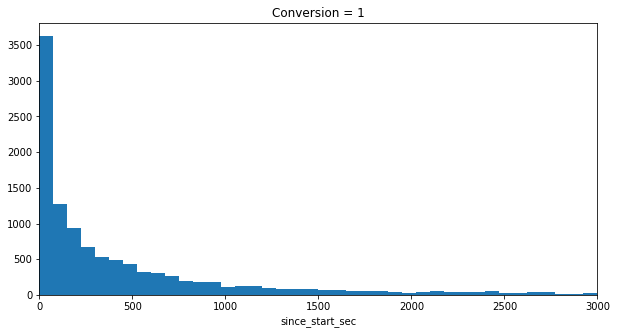

In [34]:
plt.figure(figsize=(10,5))
plt.xlabel('since_start_sec')
plt.title('Conversion = 1')
plt.xlim([0, 3000])
_ = plt.hist(clicks_conv[clicks_conv['conversion'] == 1]['since_start_sec'], bins=100)

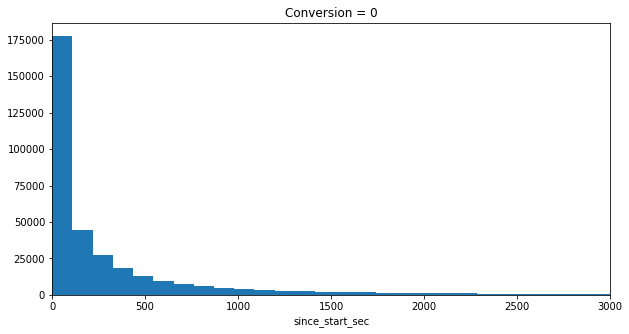

In [35]:
plt.figure(figsize=(10,5))
plt.xlabel('since_start_sec')
plt.title('Conversion = 0')
plt.xlim([0, 3000])
_ = plt.hist(clicks_conv[clicks_conv['conversion'] == 0]['since_start_sec'], bins=300)

Первый клик может быть как конверсионным, так и не конверсионным. Распределение времени клика с момента начала сессии для конверсионных и не конверсионных случаев практически одинаковое. Для неконверсионных случаев характерны очень длинные сессии > 7000 секунд.

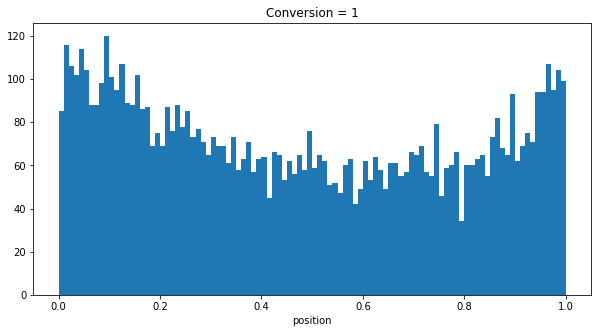

In [36]:
plt.figure(figsize=(10,5))
plt.xlabel('position')
plt.title('Conversion = 1')
_ = plt.hist(clicks_conv[(clicks_conv['conversion'] == 1) & \
                         (clicks_conv['position'] < 1) & \
                        (clicks_conv['position'] > 0)]['position'], bins=100)

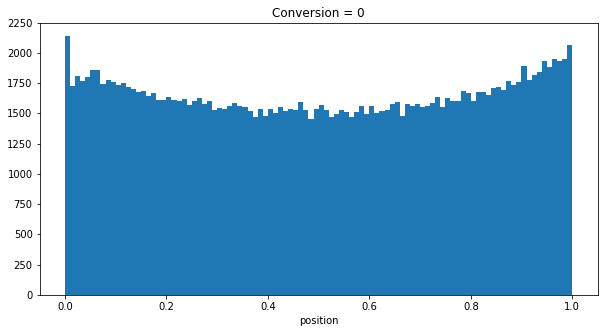

In [37]:
plt.figure(figsize=(10,5))
plt.xlabel('position')
plt.title('Conversion = 0')
_ = plt.hist(clicks_conv[(clicks_conv['conversion'] == 0) & \
                         (clicks_conv['position'] < 1) & \
                        (clicks_conv['position'] > 0)]['position'], bins=100)

Апостериорно рассмотрим в какой момент сессии (где 0 -- начало, а 1 -- окончание) чаще происходят конверсионные клики. Клики без покупок распределены более равномерно, тогда как конверсионных кликов больше в начале и в конце сессии. Однако данная информация не может быть использована в модели, поскольку становится известна лишь после окончания сессии.

----------

## Предсказание конверсии клика

In [38]:
y = clicks_conv['conversion']
X = clicks_conv[['special', 'since_start_sec',
       'cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5',
       'cat_6', 'cat_7', 'cat_8', 'cat_9', 'cat_10', 'cat_11', 'cat_12']]

### Описание переменных для модели

*Special* - относится к категории спецпредложений (бинарное)

*Since_start_sec* - количество секунд прошедшее с момента первого клика

*Cat_k* - категория (реферная группа -- отсутствие категории)

*y* - купит пользователь данный товар или нет

Разделяем выборку на тестовую и обучающую, чтобы проверять качество модели на данных, которые она еще не видела

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [40]:
pd.Series(y_test).value_counts()

0    69392
1     2242
Name: conversion, dtype: int64

Выборка сильно несбалансирована, поэтому проведем ресемплинг, без него модель предсказывает класс 0 во всех случаях

In [41]:
sm = SMOTE(random_state=17)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
X_train_res = pd.DataFrame(X_train_res)
X_train_res.columns = X_train.columns

Для предсказания используем градиентный бустинг, поскольку зависимости в данных нелинейные и переменных немного, то бустинг неглубоких деревьев кажется оптимальным решением. Похожй уровень качества можно достичь при помощи случайного леса, однако xgboost работает гораздо быстрее и его показатели по метрикам несколько лучше.

In [42]:
from xgboost import XGBClassifier

modelXGBr = XGBClassifier(max_depth=2, learning_rate=0.1, n_estimators=500, \
                         objective='binary:logistic', n_jobs=-1, num_round=100, \
                         gamma=5, min_child_weight=2, max_delta_step=0, \
                         subsample=1, colsample_bytree=1, colsample_bylevel=1, \
                         reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
modelXGBr.fit(X_train_res, y_train_res)

preds_test = modelXGBr.predict(X_test)
preds_train = modelXGBr.predict(X_train_res)

score_accuracy = accuracy_score(preds_train, y_train_res)
score_precision = precision_score(preds_train, y_train_res)
score_recall = recall_score(preds_train, y_train_res)
score_f1 = f1_score(preds_train, y_train_res)

print('Train resampled:\n accuracy score: {0}\n precision score: {1}\n recall score: {2}\n f1 score: {3}\n'.format(
    score_accuracy, score_precision, score_recall, score_f1))

score_accuracy = accuracy_score(preds_test, y_test)
score_precision = precision_score(preds_test, y_test)
score_recall = recall_score(preds_test, y_test)
score_f1 = f1_score(preds_test, y_test)

print('Test:\n accuracy score: {0}\n precision score: {1}\n recall score: {2}\n f1 score: {3}\n'.format(
    score_accuracy, score_precision, score_recall, score_f1))

Train resampled:
 accuracy score: 0.6497988696329191
 precision score: 0.47199313705700857
 recall score: 0.7324666897871055
 f1 score: 0.5740652249203212

Test:
 accuracy score: 0.813189267666192
 precision score: 0.3050847457627119
 recall score: 0.05468500159897666
 f1 score: 0.09274576271186441



В качестве основных метрик были выбраны Recall и F1, поскольку в рассматриваемой ситуации мисклассификация неконверсионного клика в конверсионный не критична, гораздо важнее выявить хотя бы какое-то количество конверсионных кликов, чтобы иметь возможность таргетировать предложения на различные группы пользователей (стимулировать тех, кто еще не настроен на покупку; повышать лояльность заинтересованной аудитории).

Метрики точности в данной задаче не показательны, поскольку модель, предсказывающая только нули будет формально демонстрировать высокую точность из-за сильно несбалансированных классов. Recall показывает отношение правильно предсказанных конверсий к общему числу конверсий. F-мера является комбинацией recall и precision.

Построенная модель на тестовой выборке демонстрирует полноту (процент правильно предсказанных конверсий) 5.5%, точность 81%

Согласно построенной модели наиболее значимым параметром являются спецпредложение и время, прошедшее с начала сессии. Переменные принадлежности к категориям вносят значительно меньший вклад в модель. Более популярные категории оказывает большее влияние

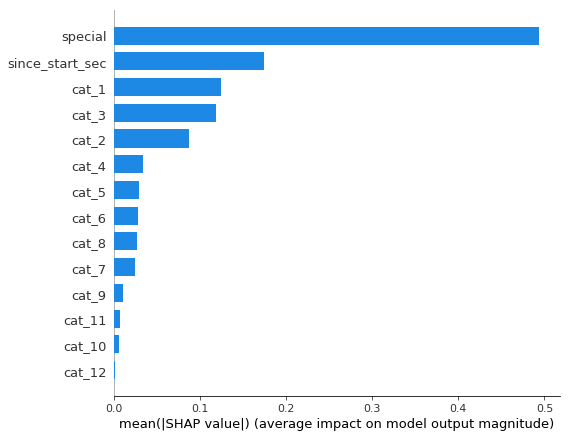

In [43]:
explainer = shap.TreeExplainer(modelXGBr)
shap_values = explainer.shap_values(X_train_res)

shap.summary_plot(shap_values, X_train_res, plot_type="bar")

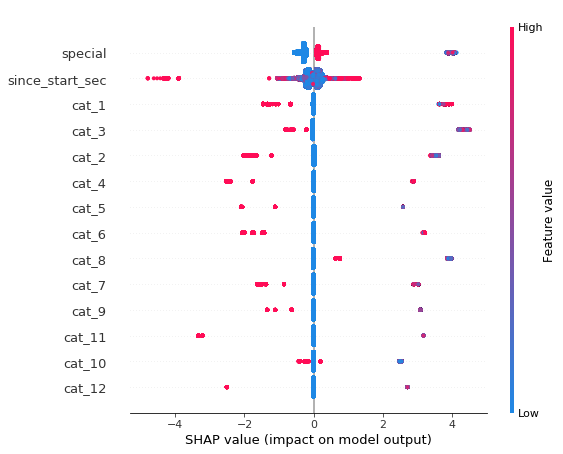

In [44]:
shap.summary_plot(shap_values, X_train_res)

Чуть более подробная интерпретация модели показывает, что принадлежность к категории в различных случаях оказывает разный эффект (значение SHAP может быть и положительным и отрицательным). Принадлежность к спецпредложениям в большинстве случаев положительно сказывается на вероятности приобретения. 

Длительная сессия также влияет по разному, скорее всего наибольшие значения влияют негативно (выброс на графике), а меньшие, но все еще достаточно большие еще могут иметь положительный эффект.

Однако, можно сказать, что модель обладает довольно слабой предсказательной силой (5% полнота это маловато) и нуждается в дополнительных источниках информации, таких как накопленная история по пользователю. Эффект рассмотренных переменных часто неоднозначен, что значительно ухудшает качество предсказаний.

----------

## Анализ конверсии сессий

In [45]:
ses_conv = ses_clicks.merge(ses_buys, on=['session_id'], how='left')

In [46]:
ses_conv['buys'].fillna(0, inplace=True)
ses_conv['conversion'] = [1 if q > 0 else 0 for q in ses_conv['buys']]

In [47]:
ses_conv = ses_conv[['special_cnt', 'clicked', 'dur_sec', 'cat_real_div', 'clicks_minute', 'conversion']]

### Описание переменных

-  *special_cnt* -- количество спецпредложений
-  *clicked* -- количество переходов 
-  *dur_sec* -- продолжительность сессии (секунд)
-  *cat_real_div* -- количество просмотренных разделов каталога (по принадлежности к ним товара)
-  *clicks_minute* -- количество кликов в минуту

In [48]:
ses_conv[ses_conv['conversion'] == 1].describe()[['special_cnt', 'clicked', 'dur_sec', 'cat_real_div', 'clicks_minute']].T

,count,mean,std,min,25%,50%,75%,max
special_cnt,2576.0,2.682065,4.418435,0.0,0.000000,1.000000,4.000000,55.000000
clicked,2576.0,6.838898,6.494872,1.0,3.000000,5.000000,9.000000,61.000000
dur_sec,2576.0,828.096639,1055.388419,0.0,146.769000,468.223000,1042.681500,8246.500000
cat_real_div,2576.0,0.364130,0.677645,0.0,0.000000,0.000000,1.000000,6.000000
clicks_minute,2576.0,2.071376,2.662302,0.0,0.642588,1.282094,2.362722,28.760408


In [49]:
ses_conv[ses_conv['conversion'] == 0].describe()[['special_cnt', 'clicked', 'dur_sec', 'cat_real_div', 'clicks_minute']].T

,count,mean,std,min,25%,50%,75%,max
special_cnt,97424.0,1.118503,2.162584,0.0,0.000000,0.000000,2.000000,90.000000
clicked,97424.0,3.483351,3.562653,1.0,2.000000,2.000000,4.000000,161.000000
dur_sec,97424.0,371.219628,733.088130,0.0,30.654500,123.691000,369.350500,32645.774000
cat_real_div,97424.0,0.239900,0.481865,0.0,0.000000,0.000000,0.000000,8.000000
clicks_minute,97424.0,1.525910,2.805892,0.0,0.226823,0.702016,1.566676,35.438433


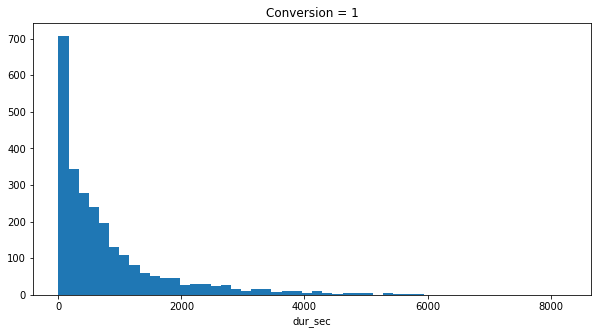

In [50]:
plt.figure(figsize=(10,5))
plt.xlabel('dur_sec')
plt.title('Conversion = 1')
_ = plt.hist(ses_conv[ses_conv['conversion'] == 1]['dur_sec'], bins=50)

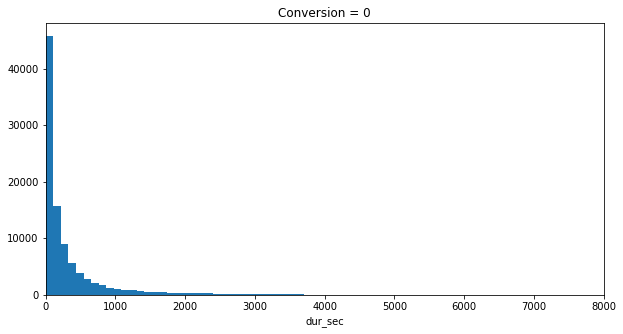

In [51]:
plt.figure(figsize=(10,5))
plt.xlabel('dur_sec')
plt.xlim([0, 8000])
plt.title('Conversion = 0')
_ = plt.hist(ses_conv[ses_conv['conversion'] == 0]['dur_sec'], bins=300)

Распределение прололжительности сессий более пологое для конверсионных случаев, там больше коротких сессий и хвост распределения значительно короче. Это может говорить о том, что пользователи часто приходят совершить обдуманную покупку или же не тратям много времени на обдумывание.

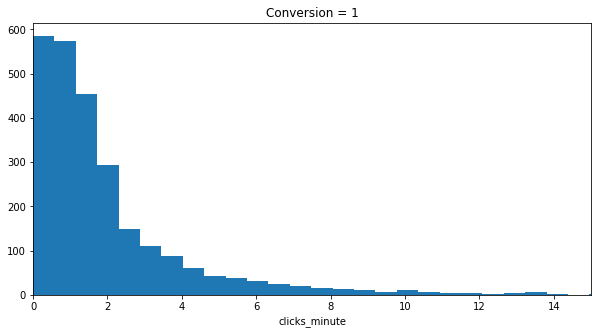

In [52]:
plt.figure(figsize=(10,5))
plt.xlabel('clicks_minute')
plt.xlim([0, 15])
plt.title('Conversion = 1')
_ = plt.hist(ses_conv[ses_conv['conversion'] == 1]['clicks_minute'], bins=50)

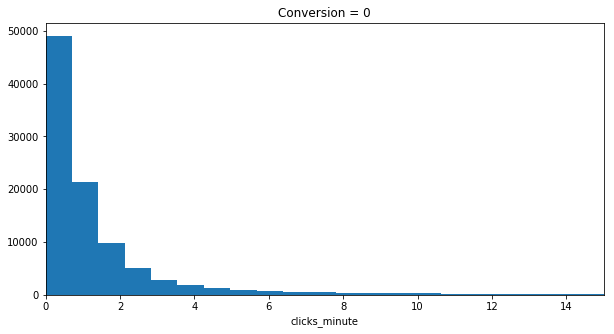

In [53]:
plt.figure(figsize=(10,5))
plt.xlabel('clicks_minute')
plt.xlim([0, 15])
plt.title('Conversion = 0')
_ = plt.hist(ses_conv[ses_conv['conversion'] == 0]['clicks_minute'], bins=50)

У разных категорий пользователей немного отличается частота кликов. Покупающие пользователи склонны совершать 0-2 клика в минуту.

Покупающие пользователи более заинтересованы в специальных предложениях, совершают больше кликов (в абсолютных значениях) и в среднем проводят больше времени на сайте.

----------

## Предсказание конверсии сессии

Используем такую же спецификацию модели с другими настройками

In [54]:
y = ses_conv['conversion']
X = ses_conv[['special_cnt', 'clicked', 'dur_sec', 'cat_real_div', 'clicks_minute']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [55]:
sm = SMOTE(random_state=17)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
X_train_res = pd.DataFrame(X_train_res)
X_train_res.columns = X_train.columns

In [56]:
from xgboost import XGBClassifier

modelXGBr = XGBClassifier(max_depth=3, learning_rate=0.05, n_estimators=500, \
                         objective='binary:logistic', n_jobs=-1, num_round=200, \
                         gamma=15, min_child_weight=2, max_delta_step=0, \
                         subsample=0.9, colsample_bytree=1, colsample_bylevel=1, \
                         reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
modelXGBr.fit(X_train_res, y_train_res)

preds_test = modelXGBr.predict(X_test)
preds_train = modelXGBr.predict(X_train_res)

score_accuracy = accuracy_score(preds_train, y_train_res)
score_precision = precision_score(preds_train, y_train_res)
score_recall = recall_score(preds_train, y_train_res)
score_f1 = f1_score(preds_train, y_train_res)

print('Train resampled:\n accuracy score: {0}\n precision score: {1}\n recall score: {2}\n f1 score: {3}\n'.format(
    score_accuracy, score_precision, score_recall, score_f1))

score_accuracy = accuracy_score(preds_test, y_test)
score_precision = precision_score(preds_test, y_test)
score_recall = recall_score(preds_test, y_test)
score_f1 = f1_score(preds_test, y_test)

print('Test:\n accuracy score: {0}\n precision score: {1}\n recall score: {2}\n f1 score: {3}\n'.format(
    score_accuracy, score_precision, score_recall, score_f1))

Train resampled:
 accuracy score: 0.903234705399302
 precision score: 0.8341074727981934
 recall score: 0.9679278152499218
 f1 score: 0.8960488500796019

Test:
 accuracy score: 0.9495
 precision score: 0.119140625
 recall score: 0.09838709677419355
 f1 score: 0.10777385159010601



Данная модель работает лучше предыдущей (все метрики выше, кроме precision, который не очень важен в нашей ситуации). 10% из классифицированных как потенциальные покупатели в действительности ими являются. Общая точность модели 95%.

In [57]:
explainer = shap.TreeExplainer(modelXGBr)
shap_values = explainer.shap_values(X_train_res)

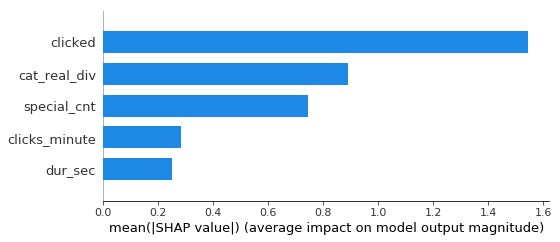

In [58]:
shap.summary_plot(shap_values, X_train_res, plot_type="bar")

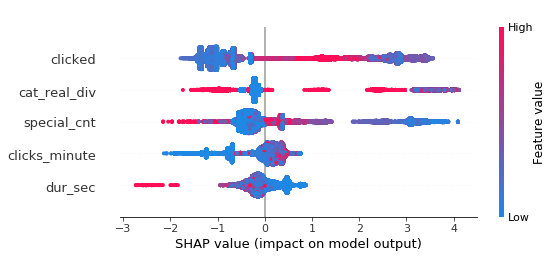

In [59]:
shap.summary_plot(shap_values, X_train_res)

Наиболее значимой переменной в модели является количество кликов, на графике явно видно, что небольшое количество переходов может влиять на вероятность как отрицательно, так и положительно. Эффект от большого количества переходов положительный. То есть можно предположить, что мало кликают либо люди, пришедшие с целью покупки определенного товара и незаинтересованные ни в чем больше, так и просто незаинтересованные пользователи.

Эффект от количества просмотренных разделов также неоднозначный.

Интересно, что количество просмотренных спецпредложений имеет тенденцию к отрицательному влиянию. Много кликов на спецпредложения негативно сказываются на вероятности покупки. Незаинтересованность в спецпредложениях может иметь как сильно положительный, так и (хоть и ощутимо меньший) отрицательный эффект.

Более частые переходы по сайту положительно влияют на вероятность покупки. Продолжительность сессии оказывает негативное влияние на вероятность.

-------------

## Выводы

Таким образом были построены модели, предсказывающие конверсию клика и сессии в целом. Задача предсказания конверсии клика оказалась сложнее из за недостатка данных  сложных взаимосвязей в них. Модель предсказания конверсии по сессии оказалась лучше по метрикам (recall 10%, accuracy 95%) и может быть применена для предсказаний.

Стоит отметить, что у магазина довольно специфичная аудитория, которая характеризуется низкой активностью (средняя сессия 6.5 минут), продолжительность сессии является негативным предиктором вероятности покупки, а частота кликов -- положительный предиктор. Такое поведение может объясняться как тем, что сайт очень удобный и нужное быстро находится, так и тем, что большая чать аудитории не может в нем разобраться и быстро теряет интерес к покупкам.

Построенную модель для оценки конверсионности сессии можно применять при таргетировании акций и повышения заинтересованности аудитории,если она классифицирует пользователя как потенциально заинтересованного, а он все еще не положил ничего в корзину, то можно предложить ему скидку или подарок. Если пользователь относится к числу незаинтересованных можно предложить ему посмотреть популярные товары, товары наиболее релевантные тому, что он просматривает в данный момент  или предложить купон на скидку на просматриваемый товар с целью подтолкнуть к совершению покупки.